In [3]:
import re
import codecs

from time import time

from tqdm import tqdm
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, confusion_matrix

import seaborn as sns
%matplotlib inline

In [4]:
import os 
os.chdir("/Users/eddy/Downloads")

In [6]:
first_names = set()
last_names = set()

with codecs.open('persondata_en.nt', 'r', 'utf8') as names:
    for line in tqdm(names):
        if '<http://xmlns.com/foaf/0.1/surname>' in line and "@en" in line:
            match = re.search('"(.+?)"@en', line)
            if match:
                last_names.add(match.group(1).lower())
        elif '<http://xmlns.com/foaf/0.1/givenName>' in line and "@en" in line:
            match = re.search('"(.+?)"@en', line)
            if match:
                first_names.add(match.group(1).lower())

8397083it [02:32, 54996.49it/s]


In [7]:
len(first_names), len(last_names)

(206054, 331377)

In [8]:
first_names = sorted(first_names)
last_names = sorted(last_names)

In [9]:
first_names[:10]

['%20johann%20michael',
 "'''ali sayyid muhamed mustafa al-",
 "'''friedrich f.",
 "'''karl georg otto willibald",
 "'''lester whyland",
 "'''major general salihu zaway",
 "'''philibert-emmanuel de froulay de",
 "'aisake",
 "'ana",
 "'antigone"]

In [10]:
first_names = [n for n in first_names if n.isalpha() and len(n) >= 3]
last_names = [n for n in last_names if n.isalpha() and len(n) >= 3]

In [11]:
print (first_names[:10])
print (last_names[:10])

['aaaa', 'aaaron', 'aabid', 'aad', 'aadarsh', 'aadel', 'aadesh', 'aadhavan', 'aadil', 'aaditya']
['aab', 'aabech', 'aabel', 'aaberg', 'aaboe', 'aaboubou', 'aabrek', 'aabrekk', 'aabrink', 'aabroo']


In [12]:
len(first_names), len(last_names)

(73738, 282833)

In [14]:
with codecs.open('corncob_lowercase.txt', 'r', 'utf-8') as words:
    non_names = {w.strip() for w in words}

non_names = non_names - set(first_names)- set(last_names)
non_names = sorted(non_names)

In [15]:
print (non_names[:10])

['aardvark', 'aardwolf', 'aback', 'abaft', 'abalone', 'abandon', 'abandoned', 'abandonment', 'abandons', 'abase']


In [16]:
len(non_names)

50665

In [17]:
def train_val_test(input, seed=1):
    np.random.seed(seed)
    n = len(input) / 5
    test = set(np.random.choice(input, size=n, replace=False))
    alltrain = set(input) - test

    n = len(alltrain) / 5
    val = set(np.random.choice(list(alltrain), size=n, replace=False))
    train = alltrain - val
    return list(train), list(val), list(test)

first_train, first_val, first_test = train_val_test(first_names)
last_train, last_val, last_test = train_val_test(last_names)
words_train, words_val, words_test = train_val_test(non_names)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [18]:

print (first_train[:10])
print (first_val[:10])
print (first_test[:10])

print()

print (last_train[:10])
print (last_val[:10])
print (last_test[:10])

['alidou', 'davydd', 'kirk', 'raffaello', 'kirksey', 'yuny', 'nusa', 'hirooki', 'sharrod', 'morvan']
['nesrine', 'jianqing', 'asomatianos', 'ophir', 'johane', 'matar', 'vontez', 'nelsan', 'saishu', 'waldick']
['cleto', 'husna', 'rahera', 'lifetu', 'khulekani', 'gambier', 'shaoguang', 'izzatullah', 'hampden', 'meline']

['loesener', 'kirk', 'kirksey', 'alpizar', 'musisi', 'zagame', 'odifreddi', 'gasteiger', 'semanick', 'autun']
['morvan', 'bulgarin', 'abt', 'ridding', 'eeg', 'nerezov', 'deahm', 'tangora', 'pihl', 'lupino']
['hiraethog', 'wilmots', 'andriacchi', 'slipak', 'sleaver', 'vanse', 'uslu', 'franel', 'dumichen', 'owatari']


In [19]:
def prepare_data(first, last, words, target_size, seed=1):
    np.random.seed(seed)

    positive_n = target_size / 8
    negagive_n = 5 * target_size / 8


    valid_names = pd.DataFrame({
            'first': np.random.choice(first, size=positive_n), 
            'second': np.random.choice(last, size=positive_n)})
    valid_names['target'] = 1

    part_name_1 = pd.DataFrame({
            'first': np.random.choice(words, size=positive_n),
            'second': np.random.choice(first, size=positive_n), 
            })
    part_name_1['target'] = 0

    part_name_2 = pd.DataFrame({
            'first': np.random.choice(last, size=positive_n),
            'second': np.random.choice(words, size=positive_n)
            })
    part_name_2['target'] = 0

    not_names = pd.DataFrame({
            'first': np.random.choice(words, size=negagive_n),
            'second': np.random.choice(words, size=negagive_n)
            })
    not_names['target'] = 0

    result = pd.concat([valid_names, part_name_1, part_name_2])
    result = pd.concat([result, not_names]).reset_index(drop=1)

    result['candidate'] = result['first'] + ' ' + result['second']
    del result['first'], result['second']
    result = result.reindex(np.random.permutation(result.index))
    return result

In [20]:

df_train = prepare_data(first_test, last_test, words_train, target_size=500000)
df_train.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-in

,target,candidate
426181,0,hooray wolfishly
418277,0,fugitives excavator
56705,1,vallance wuhayshi
206685,0,tunic wildebeest
216313,0,ingenuousness democratising


In [21]:
df_train.target.mean()

0.125

In [22]:

df_val = prepare_data(first_val, last_val, words_val, target_size=150000)
df_val.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-in

,target,candidate
141970,0,kilovolt armlets
9616,1,ntone saradzhev
14536,1,jihad bueil
74275,0,clattering thirteen
18725,1,changjun furtney


In [23]:
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), min_df=10)
X = tfidf.fit_transform(df_train.candidate)
y = df_train.target

X.shape

(500000, 58168)

In [24]:
X_val = tfidf.transform(df_val.candidate)
y_val = df_val.target

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


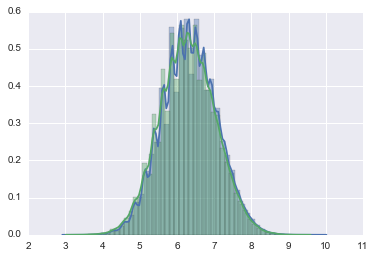

In [25]:
sns.distplot(X.sum(axis=1))
sns.distplot(X_val.sum(axis=1))

In [26]:
for C in [0.0001, 0.001, 0.01, 0.1, 0.5]:
    t0 = time()
    svm = LinearSVC(penalty='l1', dual=False, random_state=1, C=C)
    svm.fit(X, y)

    print ('fit for C=%f took %0.3fs' % (C, time() - t0))
    res = svm.decision_function(X_val)
    auc = roc_auc_score(y_val, res)
    print ('auc=%0.5f' % (auc))

fit for C=0.000100 took 5.069s
auc=0.50000
fit for C=0.001000 took 5.177s
auc=0.87327
fit for C=0.010000 took 32.993s
auc=0.94926
fit for C=0.100000 took 13831.952s
auc=0.97741
fit for C=0.500000 took 276.227s
auc=0.98202


In [27]:
df_train_full = pd.concat([df_train, df_val])
df_train_full.shape

(650000, 2)

In [28]:
df_test = prepare_data(first_test, last_test, words_test, target_size=150000)
df_test.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-in

,target,candidate
92649,0,elects auction
6618,1,yordanos hawke
2952,1,marama deladerriere
57321,0,paramilitaries reformulated
17841,1,biggs norregaard


In [29]:
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), min_df=10)
X = tfidf.fit_transform(df_train_full.candidate)
y = df_train_full.target
X_test = tfidf.transform(df_test.candidate)
y_test = df_test.target

In [30]:
best_C = 0.5

t0 = time()
svm = LinearSVC(penalty='l1', dual=False, random_state=1, C=best_C)
svm.fit(X, y)

print ('fit for C=%f took %0.3fs' % (C, time() - t0))
res = svm.decision_function(X_test)
auc = roc_auc_score(y_test, res)
print ('auc=%0.5f' % (auc))

fit for C=0.500000 took 369.058s
auc=0.99005


In [31]:
predicted_labels = (res > 0).astype(int)
(tp, fn), (fp, tn) = confusion_matrix(y_test, predicted_labels) 

p = 1.0 * tp / (tp + fp)
r = 1.0 * tp / (tp + fn)
print ('precision = %.4f' % p)
print ('recall    = %.4f' % r)
print ('f1        = %.4f' % (2 * p * r / (p + r)))

precision = 0.9854
recall    = 0.9750
f1        = 0.9802


In [32]:
results = df_test.copy()
results.insert(1, 'predicted', predicted_labels)

print ('incorrectly classified')
results[predicted_labels != y_test].sample(n=20, random_state=1)

incorrectly classified


,target,predicted,candidate
63999,0,1,shrink lewd
15995,1,0,stevens axgren
35597,0,1,drunkard sadaharu
1736,1,0,doming keilman
41447,0,1,lotzkar pinions
7072,1,0,shawntae modise
48432,0,1,okpebholo garotte
21730,0,1,doge antoniazzo
21455,0,1,plebeian bai
120057,0,1,erase etui


In [34]:
print ('names correctly classified')
results[(y_test == 1) & (predicted_labels == y_test)].sample(n=10, random_state=1)

names correctly classified


,target,predicted,candidate
9091,1,1,brit sulaitis
5504,1,1,toramori lavillenie
8450,1,1,jawn rillo
16050,1,1,egutu sitoci
4901,1,1,shongjian smolianoff
6830,1,1,alencar zinzun
5439,1,1,edyth carabante
14639,1,1,borey hendou
10504,1,1,satyo dattatreya
1497,1,1,falesa dorothy


In [35]:
print ('not names correctly classified')
results[(y_test == 0) & (predicted_labels == y_test)].sample(n=10, random_state=1)

not names correctly classified


,target,predicted,candidate
57005,0,0,stairway fearlessness
91571,0,0,organisation resiting
83341,0,0,chubbiness oceanic
109372,0,0,contents hoisting
56568,0,0,grandeur granddaughters
127602,0,0,staffroom exacting
122030,0,0,rare homologues
103098,0,0,mockery accusers
83184,0,0,sphinx convention
34941,0,0,fascinatingly fashad
